In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
import sklearn.model_selection as skm
import sklearn.linear_model as skl
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

In [9]:
from sklearn.tree import (DecisionTreeRegressor as DTR ,
plot_tree ,
export_text)
from sklearn.linear_model import Ridge
from sklearn.metrics import (accuracy_score , mean_squared_error, r2_score,
log_loss)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from patsy import dmatrix
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from ISLP.models import \
(sklearn_selected ,
sklearn_selection_path)

In [10]:
df = pd.read_csv(r"C:\Users\ejbor\Data Science and BA - Jupyter Lab\SeoulBikeData.csv",  encoding='unicode_escape')
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Data Cleaning

In [15]:
df.columns = df.columns.str.lower()

In [17]:
df.columns = df.columns.str.replace(r'\s*\(', '(', regex=True)

In [19]:
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
df['date'] = df['date'].astype('int64') // 10**9

In [21]:
df['functioning day'] = df['functioning day'].map({'No': 0, 'Yes': 1})

In [23]:
df.drop(['seasons', 'holiday'], axis=1, inplace=True)
df.head()

,date,rented bike count,hour,temperature(°c),humidity(%),wind speed(m/s),visibility(10m),dew point temperature(°c),solar radiation(mj/m2),rainfall(mm),snowfall(cm),functioning day
0,1512086400,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,1512086400,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,1512086400,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,1512086400,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,1512086400,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


In [25]:
null_vals = df.isnull().sum()
print(null_vals)

date                         0
rented bike count            0
hour                         0
temperature(°c)              0
humidity(%)                  0
wind speed(m/s)              0
visibility(10m)              0
dew point temperature(°c)    0
solar radiation(mj/m2)       0
rainfall(mm)                 0
snowfall(cm)                 0
functioning day              0
dtype: int64


In [27]:
df.dtypes

date                           int64
rented bike count              int64
hour                           int64
temperature(°c)              float64
humidity(%)                    int64
wind speed(m/s)              float64
visibility(10m)                int64
dew point temperature(°c)    float64
solar radiation(mj/m2)       float64
rainfall(mm)                 float64
snowfall(cm)                 float64
functioning day                int64
dtype: object

## EDA

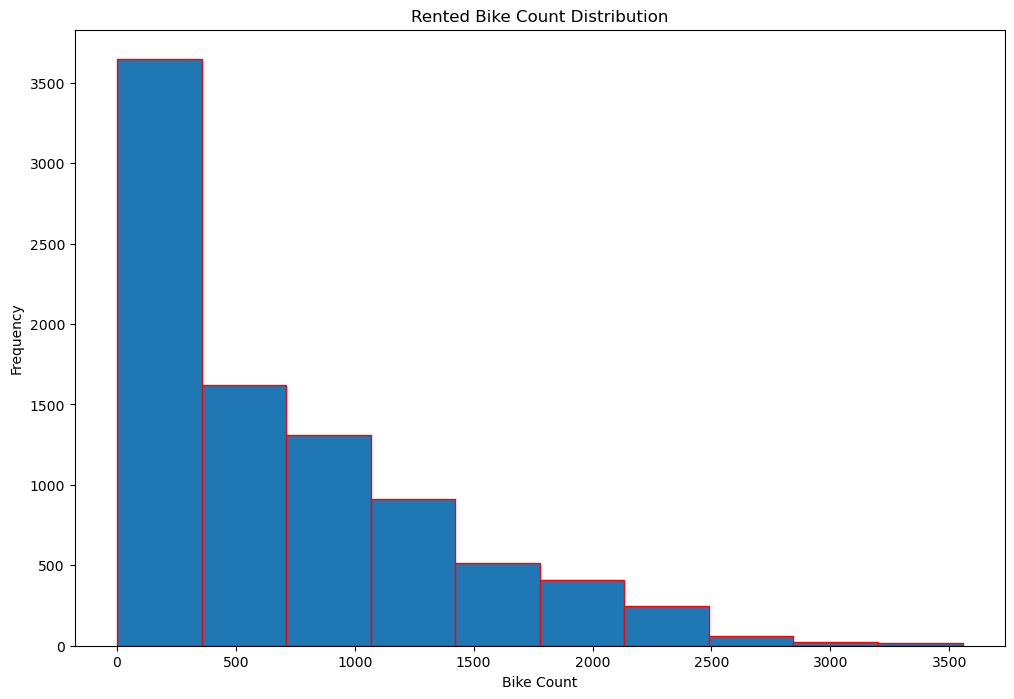

In [23]:
fig, ax = plt.subplots(figsize=(12,8))

song_popularity_hist = plt.hist(df['rented bike count'].dropna(), edgecolor='red')
plt.title("Rented Bike Count Distribution")
plt.xlabel("Bike Count")
plt.ylabel("Frequency")
plt.show()

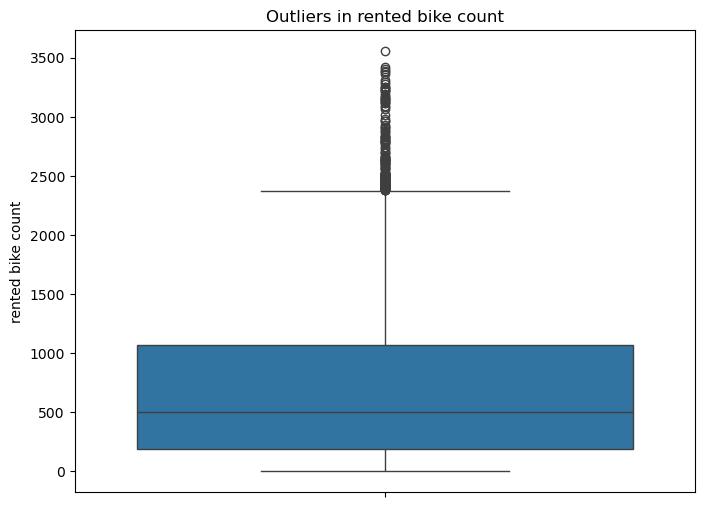

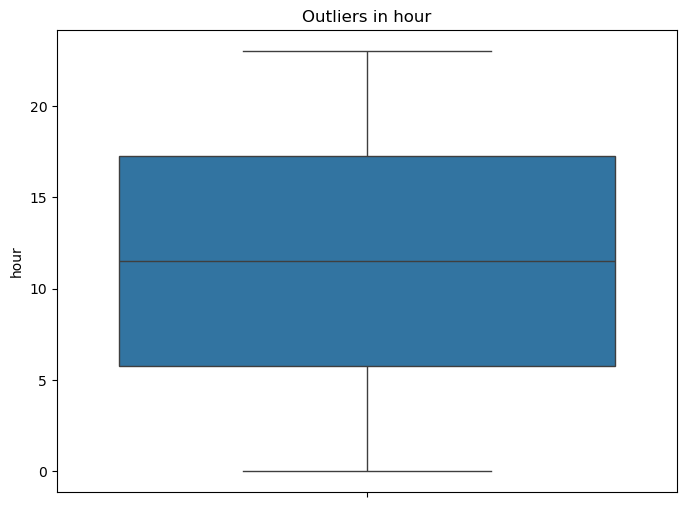

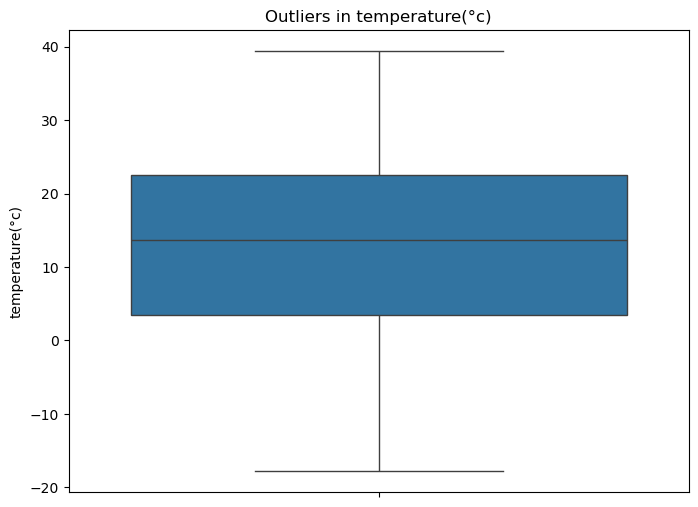

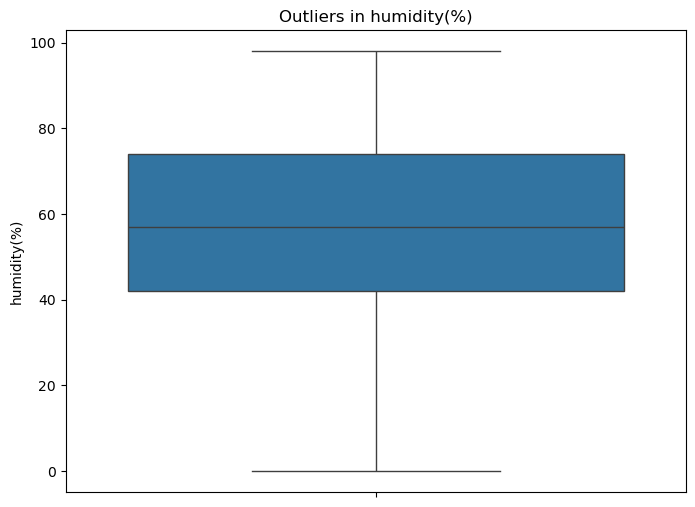

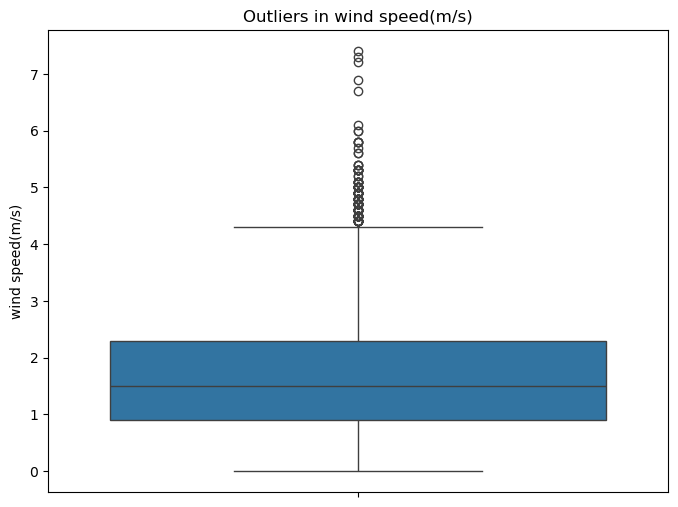

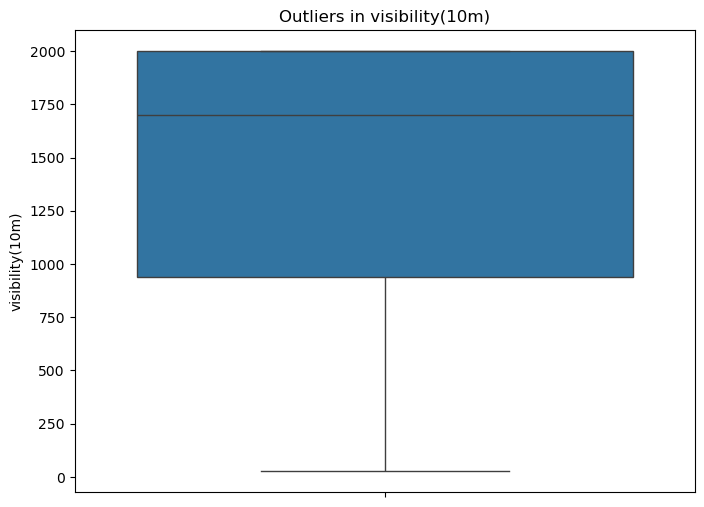

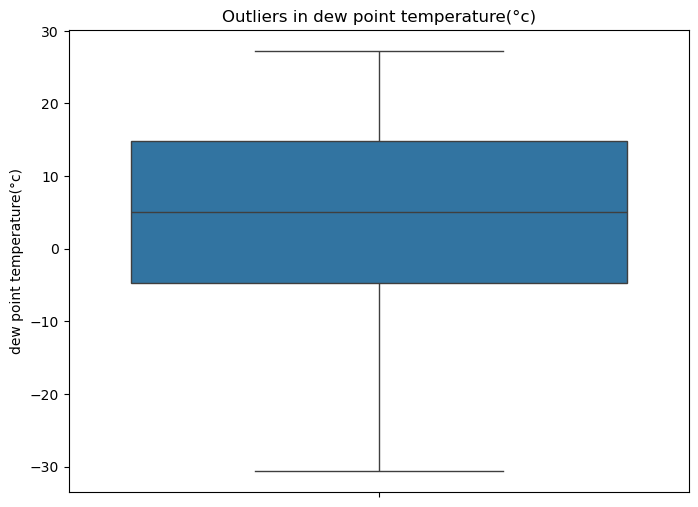

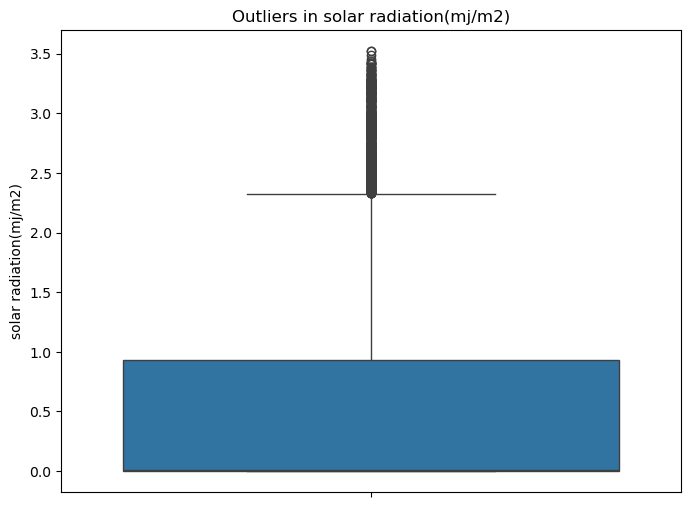

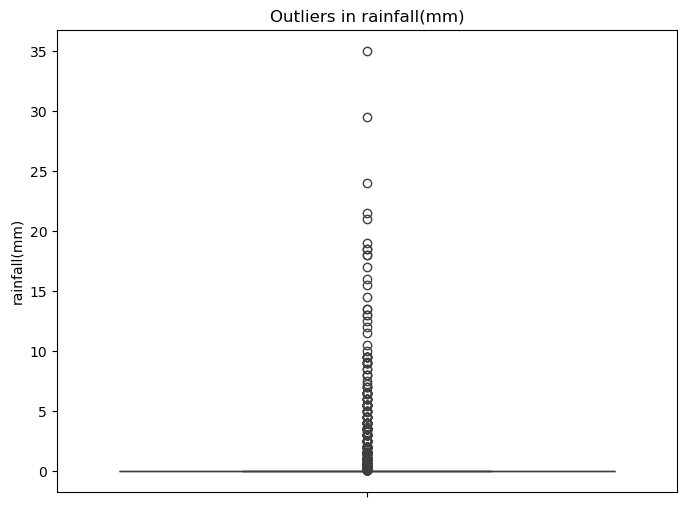

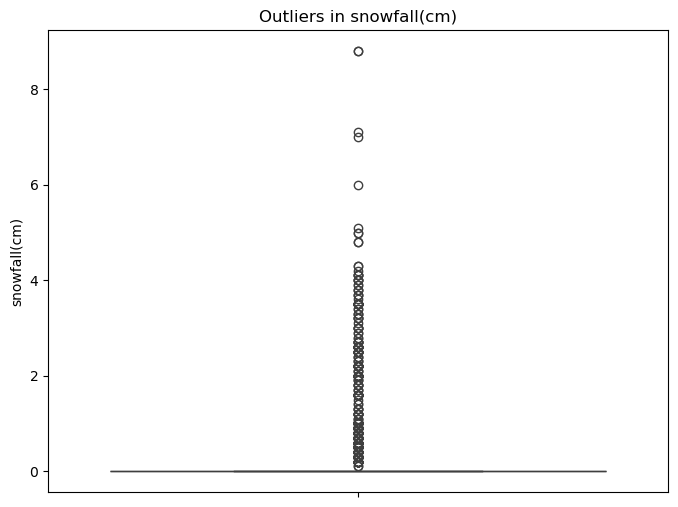

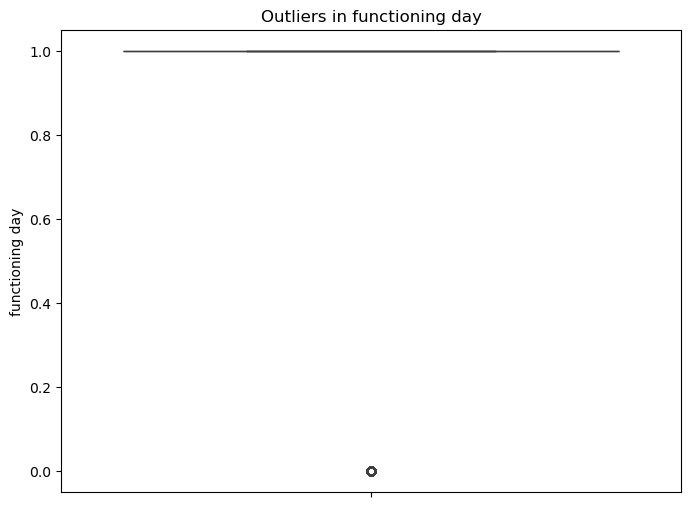

In [75]:
import seaborn as sns
columns_box_plot = ['rented bike count', 'hour', 'temperature(°c)', 'humidity(%)', 'wind speed(m/s)', 'visibility(10m)', 'dew point temperature(°c)', 'solar radiation(mj/m2)',
                    'rainfall(mm)', 'snowfall(cm)', 'functioning day']

for column in columns_box_plot:
    if pd.api.types.is_numeric_dtype(df[column]):
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=df[column])
        plt.title(f'Outliers in {column}')
        plt.show()
    else:
        print(f'Skipping non-numeric column: {column}')

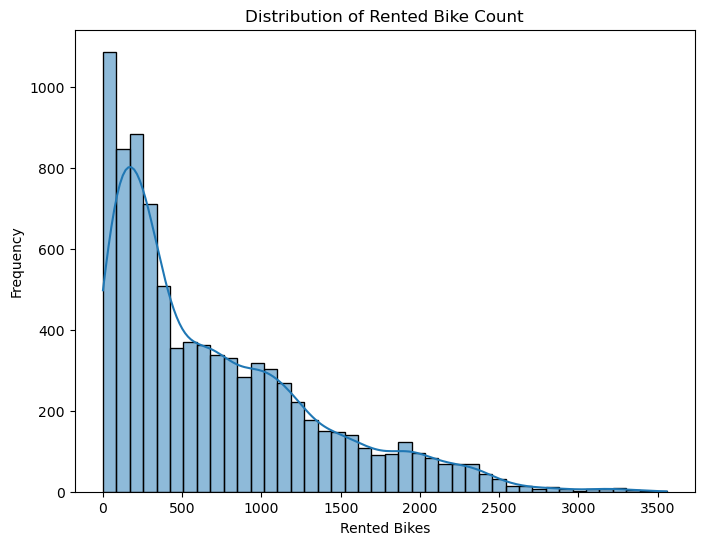

In [85]:
plt.figure(figsize=(8, 6))
sns.histplot(df['rented bike count'].dropna(), kde=True)
plt.title("Distribution of Rented Bike Count")
plt.xlabel("Rented Bikes")
plt.ylabel("Frequency")
plt.show()

## Modeling

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_standardized = scaler.fit_transform(df)

df= pd.DataFrame(df_standardized, columns=df.columns)

In [31]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.interpolate import UnivariateSpline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = df.drop(columns=['rented bike count'])
y = df['rented bike count']
results = {
    'Regression Tree': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Ridge Regression': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Lasso Regression': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Principal Component Regression (PCR)': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Regression Splines': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []},
    'Support Vector Regression': {'Test MSE': [], 'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []}
}
num_features = X.shape[1]

for _ in range(20):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

    
    models = {
        'Regression Tree': DecisionTreeRegressor(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Principal Component Regression (PCR)': make_pipeline(StandardScaler(), PCA(n_components=num_features), LinearRegression()),
        'Regression Splines': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
        'Support Vector Regression': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    }
    
    for model_name, model in models.items():
        
            
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
      
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        rss = np.sum((y_test - y_pred) ** 2)
        rse = np.sqrt(rss / (len(y_test) - X_test.shape[1] - 1))
        r2 = r2_score(y_test, y_pred)
        
        
        results[model_name]['Test MSE'].append(mse)
        results[model_name]['Test RMSE'].append(rmse)
        results[model_name]['Test RSE'].append(rse)
        results[model_name]['Test RSS'].append(rss)
        results[model_name]['Test R^2'].append(r2)

# Calculate average performance for each model
average_results = {model: {metric: np.mean(scores) for metric, scores in metrics.items()} for model, metrics in results.items()}

# Display results
results_df = pd.DataFrame(average_results).T
results_df


,Test MSE,Test RMSE,Test RSE,Test RSS,Test R^2
Regression Tree,2.220326e-01,4.710245e-01,4.721035e-01,5.835016e+02,7.793682e-01
Ridge Regression,4.689932e-01,6.847591e-01,6.863279e-01,1.232514e+03,5.343564e-01
Lasso Regression,1.008172e+00,1.003937e+00,1.006237e+00,2.649475e+03,-6.359846e-04
Principal Component Regression (PCR),4.690018e-01,6.847654e-01,6.863341e-01,1.232537e+03,5.343478e-01
Regression Splines,5.283853e+19,1.625400e+09,1.629124e+09,1.388596e+23,-5.145247e+19
Support Vector Regression,1.580146e-01,3.974544e-01,3.983649e-01,4.152624e+02,8.430680e-01


## Cross-Validation & Hypertuning

Running GridSearchCV for Ridge Regression...
Ridge Regression - Best Parameters: {'ridge__alpha': 100}
Ridge Regression - Metrics: {'MSE': 0.4712851509296516, 'RMSE': 0.6865021128369901, 'RSE': 0.6880748574247969, 'RSS': 1238.5373766431244, 'R²': 0.5216026922919706}



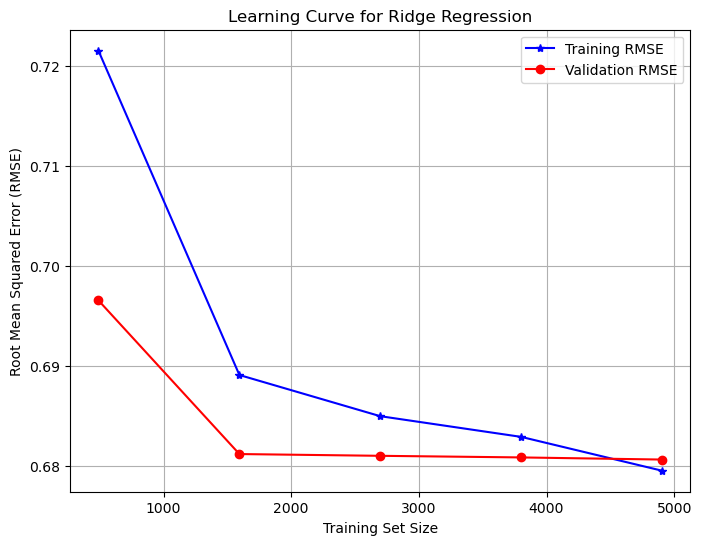

Running GridSearchCV for Lasso Regression...
Lasso Regression - Best Parameters: {'lasso__alpha': 0.01}
Lasso Regression - Metrics: {'MSE': 0.4714697433856497, 'RMSE': 0.6866365438757609, 'RSE': 0.6882095964388596, 'RSS': 1239.0224856174873, 'R²': 0.521415314154131}



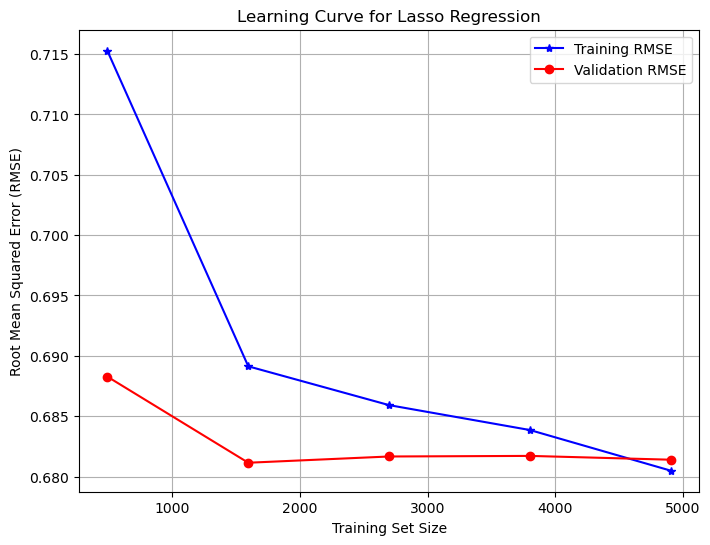

Running GridSearchCV for Principal Component Regression (PCR)...
Principal Component Regression (PCR) - Best Parameters: {'pca__n_components': 11}
Principal Component Regression (PCR) - Metrics: {'MSE': 0.47158821461635153, 'RMSE': 0.6867228077007138, 'RSE': 0.6882960578902455, 'RSS': 1239.3338280117719, 'R²': 0.5212950550759554}



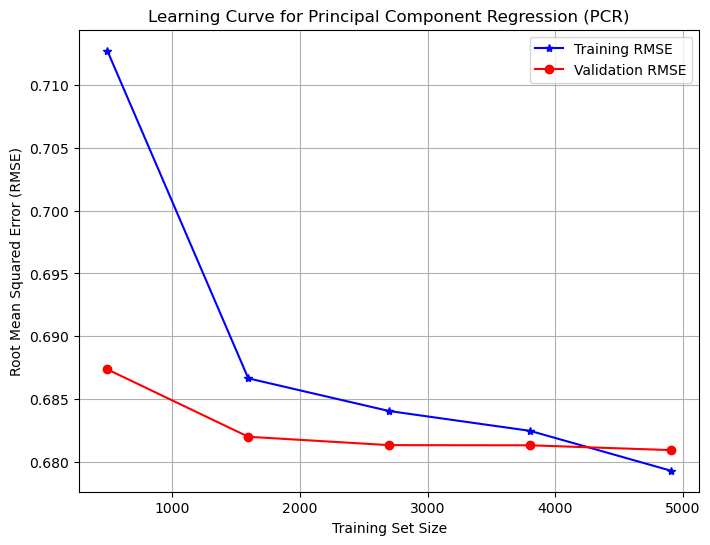

Running GridSearchCV for Regression Splines...
Regression Splines - Best Parameters: {'polynomialfeatures__degree': 2}
Regression Splines - Metrics: {'MSE': 0.36884357431042897, 'RMSE': 0.6073249330551389, 'RSE': 0.6087162863862384, 'RSS': 969.3209132878073, 'R²': 0.6255902131279862}



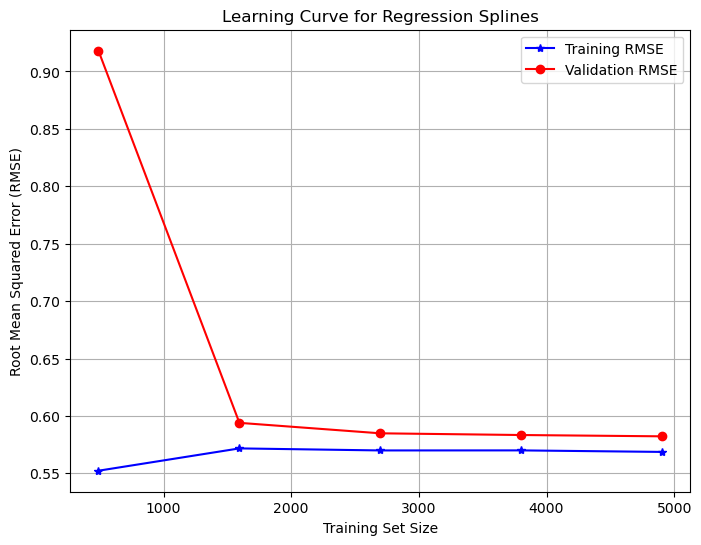

Running GridSearchCV for Regression Tree...
Regression Tree - Best Parameters: {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 10}
Regression Tree - Metrics: {'MSE': 0.29590065199338145, 'RMSE': 0.5439675100531111, 'RSE': 0.5452137144585764, 'RSS': 777.6269134386064, 'R²': 0.6996339159350801}



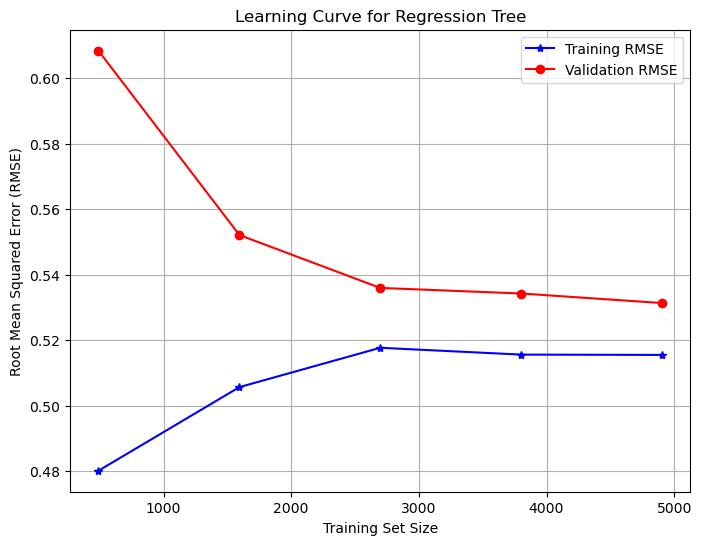

Running GridSearchCV for Support Vector Regression (SVR)...
Support Vector Regression (SVR) - Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.1}
Support Vector Regression (SVR) - Metrics: {'MSE': 0.20910630720018444, 'RMSE': 0.45728143106864116, 'RSE': 0.4583290416766343, 'RSS': 549.5313753220847, 'R²': 0.7877380728164112}



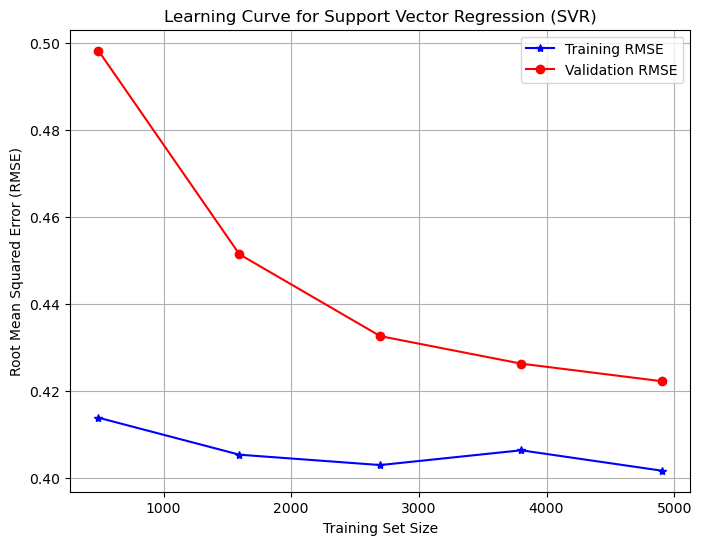


Model Performance Metrics:
                                           MSE      RMSE       RSE  \
Ridge Regression                      0.471285  0.686502  0.688075   
Lasso Regression                      0.471470  0.686637  0.688210   
Principal Component Regression (PCR)  0.471588  0.686723  0.688296   
Regression Splines                    0.368844  0.607325  0.608716   
Regression Tree                       0.295901  0.543968  0.545214   
Support Vector Regression (SVR)       0.209106  0.457281  0.458329   

                                              RSS        R²  
Ridge Regression                      1238.537377  0.521603  
Lasso Regression                      1239.022486  0.521415  
Principal Component Regression (PCR)  1239.333828  0.521295  
Regression Splines                     969.320913  0.625590  
Regression Tree                        777.626913  0.699634  
Support Vector Regression (SVR)        549.531375  0.787738  

Best Parameters for Each Model:
Ridge Regressi

In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Ridge Regression': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]},
    'Lasso Regression': {'lasso__alpha': [0.01, 0.1, 1, 10, 100]},
    'Principal Component Regression (PCR)': {'pca__n_components': [1, 2, 3, 4, X.shape[1]]},
    'Regression Splines': {'polynomialfeatures__degree': [2, 3, 4]},
    'Regression Tree': {
      'decisiontreeregressor__max_depth': [3, 4, 5],
      'decisiontreeregressor__min_samples_split': [10, 15, 20],
      'decisiontreeregressor__min_samples_leaf': [4, 8, 10]
},
    'Support Vector Regression (SVR)': {'svr__C': [0.1, 1, 10], 'svr__epsilon': [0.1, 0.5, 1]}
}



# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, n_features):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    rss = np.sum((y_true - y_pred) ** 2)
    rse = np.sqrt(rss / (len(y_true) - n_features - 1))
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'RSE': rse, 'RSS': rss, 'R²': r2}

# Function to plot learning curves
def plot_learning_curve(model, X, y, model_name, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    test_rmse = np.sqrt(-test_scores.mean(axis=1))

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_rmse, label="Training RMSE", marker='*', color='blue')
    plt.plot(train_sizes, test_rmse, label="Validation RMSE", marker='o', color='red')
    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.legend()
    plt.grid()
    plt.show()

# Dictionary to store results
results = {}
best_parameters = {}

# Iterate over each model and perform GridSearchCV
for model_name, grid_params in param_grids.items():
    print(f"Running GridSearchCV for {model_name}...")
    
    # Define the model pipeline
    if model_name == 'Principal Component Regression (PCR)':
        model = make_pipeline(StandardScaler(), PCA(), LinearRegression())
    elif model_name == 'Regression Splines':
        model = make_pipeline(PolynomialFeatures(), LinearRegression())
    elif model_name == 'Ridge Regression':
        model = make_pipeline(StandardScaler(), Ridge(max_iter=5000))
    elif model_name == 'Lasso Regression':
        model = make_pipeline(StandardScaler(), Lasso(max_iter=5000))
    elif model_name == 'Regression Tree':
        model = make_pipeline(StandardScaler(), DecisionTreeRegressor())
    elif model_name == 'Support Vector Regression (SVR)':
        model = make_pipeline(StandardScaler(), SVR())

    # Perform GridSearchCV
    grid_search = GridSearchCV(model, grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    # Store the best parameters
    best_parameters[model_name] = grid_search.best_params_
    
    # Predict on the test set using the best estimator
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    # Calculate performance metrics
    metrics = calculate_metrics(y_test, y_pred, X_test_scaled.shape[1])
    results[model_name] = metrics

    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} - Metrics: {metrics}\n")

    # Plot learning curve for the best model
    plot_learning_curve(best_model, X_train_scaled, y_train, model_name)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print("\nModel Performance Metrics:")
print(results_df)

# Display best parameters for each model
print("\nBest Parameters for Each Model:")
for model_name, params in best_parameters.items():
    print(f"{model_name}: {params}")

In [171]:
param_grids_lasso = {'Lasso Regression': {'lasso__alpha': [0.01, 0.1, 1, 10]}}
results_lasso = {model: {'Test MSE': [],  'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []} for model in param_grids_lasso.keys()}
best_params_lasso = {}
iterations = 20

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}/{iterations}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42 + iteration)
    
    for model_name, grid_params in param_grids_lasso.items():
        try:
            if model_name == 'Lasso Regression':
                model = make_pipeline(StandardScaler(), Lasso(max_iter=5000))
    
            grid_search_lasso = GridSearchCV(
                model, grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
            )
            grid_search_lasso.fit(X_train, y_train)

            # Get the best model and parameters
            best_model_lasso = grid_search_lasso.best_estimator_
            best_params_lasso[model_name] = grid_search_lasso.best_params_

            # Make predictions
            y_train_pred_lasso = best_model.predict(X_train)
            y_test_pred_lasso = best_model.predict(X_test)

            # Calculate metrics
            test_mse_lasso = mean_squared_error(y_test, y_test_pred)
            test_rmse_lasso = np.sqrt(test_mse)
            test_rss_lasso= np.sum((y_test - y_test_pred) ** 2)
            test_rse_lasso = np.sqrt(test_rss / (len(y_test) - X_test.shape[1] - 1)) if len(y_test) > X_test.shape[1] + 1 else np.nan
            test_r2_lasso = r2_score(y_test, y_test_pred)

            # Store results
            results_lasso[model_name]['Test MSE'].append(test_mse_lasso)
            results_lasso[model_name]['Test RMSE'].append(test_rmse_lasso)
            results_lasso[model_name]['Test RSE'].append(test_rse_lasso)
            results_lasso[model_name]['Test RSS'].append(test_rss_lasso)
            results_lasso[model_name]['Test R^2'].append(test_r2_lasso)

        except Exception as e:
            print(f"Error with {model_name}: {e}")

# Calculate average results
average_results_lasso = {
    model: {metric: np.mean(scores) for metric, scores in metrics.items()}
    for model, metrics in results_lasso.items()
}

print("Best Hyperparameters for Lasso Regression Model:")
for model_name, params in best_params_lasso.items():
    print(f"{model_name}: {params}")

results_df_lasso= pd.DataFrame(average_results_lasso).T
results_df_lasso

Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20
Best Hyperparameters for Lasso Regression Model:
Lasso Regression: {'lasso__alpha': 0.01}


,Test MSE,Test RMSE,Test RSE,Test RSS,Test R^2
Lasso Regression,1.751752,0.479948,0.481047,4603.603119,-0.75251


In [177]:
param_grids_pcr = {'Principal Component Regression (PCR)': {'pca__n_components': [3, 5, 6, 7, 8]}}
results_pcr = {model: {'Test MSE': [],  'Test RMSE': [], 'Test RSE': [], 'Test RSS': [], 'Test R^2': []} for model in param_grids_pcr.keys()}
best_params_pcr = {}
iterations = 20

for iteration in range(iterations):
    print(f"Iteration {iteration + 1}/{iterations}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42 + iteration)
    
    for model_name, grid_params in param_grids_pcr.items():
        try:
            if model_name == 'Principal Component Regression (PCR)':
                model = make_pipeline(StandardScaler(), PCA(), LinearRegression())
    
            grid_search_pcr = GridSearchCV(
                model, grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
            )
            grid_search_pcr.fit(X_train, y_train)

            # Get the best model and parameters
            best_model_pcr = grid_search_pcr.best_estimator_
            best_params_pcr[model_name] = grid_search_pcr.best_params_

            # Make predictions
            y_train_pred_pcr = best_model.predict(X_train)
            y_test_pred_pcr = best_model.predict(X_test)

            # Calculate metrics
            test_mse_pcr = mean_squared_error(y_test, y_test_pred)
            test_rmse_pcr = np.sqrt(test_mse)
            test_rss_pcr= np.sum((y_test - y_test_pred) ** 2)
            test_rse_pcr = np.sqrt(test_rss / (len(y_test) - X_test.shape[1] - 1)) if len(y_test) > X_test.shape[1] + 1 else np.nan
            test_r2_pcr = r2_score(y_test, y_test_pred)

            # Store results
            results_pcr[model_name]['Test MSE'].append(test_mse_pcr)
            results_pcr[model_name]['Test RMSE'].append(test_rmse_pcr)
            results_pcr[model_name]['Test RSE'].append(test_rse_pcr)
            results_pcr[model_name]['Test RSS'].append(test_rss_pcr)
            results_pcr[model_name]['Test R^2'].append(test_r2_pcr)

        except Exception as e:
            print(f"Error with {model_name}: {e}")

# Calculate average results
average_results_pcr = {
    model: {metric: np.mean(scores) for metric, scores in metrics.items()}
    for model, metrics in results_pcr.items()
}

print("Best Hyperparameters for pcr Regression Model:")
for model_name, params in best_params_pcr.items():
    print(f"{model_name}: {params}")

results_df_pcr= pd.DataFrame(average_results_pcr).T
results_df_pcr

Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20
Best Hyperparameters for pcr Regression Model:
Principal Component Regression (PCR): {'pca__n_components': 8}


,Test MSE,Test RMSE,Test RSE,Test RSS,Test R^2
Principal Component Regression (PCR),1.751752,0.479948,0.481047,4603.603119,-0.75251
